## Setup

In [1]:
import os
import datetime
from pathlib import Path
from joblib import dump, load

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
df1 = pd.read_pickle("data/doh_merged_2.pkl")
df2 = pd.read_pickle("data/AmazonRing/ring_merged.pkl")
df3 = pd.read_pickle("data/Reolink/reo_merged.pkl")
df4 = pd.read_pickle("data/Telekom/telekom_magenta_homebase2.pkl")

#### Over/Undersampling dataset

In [3]:
# Shorten label names
df1['label'] = "NoLabel"
df2['label'] = "Spotlight Cam"
df3['label'] = "Argus PT"
df4['label'] = "HomeBase2"

In [4]:
sampling_before = {}
for df in [df1, df2, df3, df4]:
  print(df.iloc[0]['label'], len(df))
  sampling_before[df.iloc[0]['label']] = len(df)

NoLabel 2759326
Spotlight Cam 146591
Argus PT 34049
HomeBase2 3292


In [5]:
n = 34049 # Number of Reolink Argus PT rows

df1 = df1.sample(n=n, replace=False)
df2 = df2.sample(n=n, replace=False)
df3 = df3.sample(n=n, replace=False)
df4 = df4.sample(n=n, replace=True)


In [6]:
sampling_after = {}
for df in [df1, df2, df3, df4]:
  print(df.iloc[0]['label'], len(df))
  sampling_after[df.iloc[0]['label']] = len(df)

NoLabel 34049
Spotlight Cam 34049
Argus PT 34049
HomeBase2 34049


In [7]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)

trace1 = fig.add_trace(
    go.Bar(
      x=list(sampling_before.keys()),
      y=list(sampling_before.values()),
      name="Before Under-/Over-sampling",
      text=list(sampling_before.values())
      ),
    row=1, col=1
)

trace2 = fig.add_trace(
    go.Bar(x=list(sampling_after.keys()), y=list(sampling_after.values()), name="After Under-/Over-sampling",text=list(sampling_after.values())),
    row=1, col=2
)

fig.update_yaxes(type="log")
fig.update_layout(
  height=300, 
  width=900, 
  yaxis_title="Number of packets",
  )
fig.update_layout(
  legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="left",
    x=0
    )
  )
fig.update_layout(margin=dict(t=10, b=10))
fig.show()
fig.write_image("assets/sampling.pdf")

In [8]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [9]:
df.columns

Index(['time', 'payload', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_id',
       'IP_flags', 'IP_frag', 'IP_ttl', 'IP_proto', 'IP_chksum', 'IP_src',
       'IP_dst', 'TCP_sport', 'TCP_dport', 'TCP_seq', 'TCP_ack', 'TCP_dataofs',
       'TCP_reserved', 'TCP_flags', 'TCP_window', 'TCP_chksum', 'TCP_urgptr',
       'UDP_sport', 'UDP_dport', 'UDP_len', 'UDP_chksum', 'Raw_load',
       'IP_int_arr_time', 'IP_Burst_ix', 'IP_Burst_length',
       'IP_Burst_avg_size', 'label'],
      dtype='object')

In [10]:
df['IP_version'] = df['IP_version'].astype("string")
df['label'] = df['label'].astype("string")
na_values = {
  # "time": 0,
  "payload": "NoPayload",
  "IP_version": "0",
  "IP_ihl": 0,
  "IP_tos": 0,
  "IP_len": 0,
  "IP_id": 0,
  "IP_flags": 0,
  "IP_frag": 0,
  "IP_ttl": 0,
  "IP_proto": 0,
  "IP_chksum": 0,
  "IP_src": "0",
  "IP_dst": "0",
  "TCP_sport": "0",
  "TCP_dport": "0",
  "TCP_seq": 0,
  "TCP_ack": 0,
  "TCP_dataofs": 0,
  "TCP_reserved": 0,
  "TCP_flags": 0,
  "TCP_window": 0,
  "TCP_chksum": 0,
  "TCP_urgptr": 0,
  "UDP_sport": "0",
  "UDP_dport": "0",
  "UDP_len": 0,
  "UDP_chksum": 0,
  "Raw_load": 0,
  'IP_int_arr_time': datetime.timedelta(seconds=0), 
  'IP_Burst_ix': 0, 
  'IP_Burst_length': 0,
  'IP_Burst_avg_size': 0,
  "label": "NoLabel",
}

df.fillna(value=na_values, inplace=True)

In [11]:
for col in df.columns:
  print(col, "NA", sum(df[col].isna()), "out of", len(df[col]))

time NA 0 out of 136196
payload NA 0 out of 136196
IP_version NA 0 out of 136196
IP_ihl NA 0 out of 136196
IP_tos NA 0 out of 136196
IP_len NA 0 out of 136196
IP_id NA 0 out of 136196
IP_flags NA 0 out of 136196
IP_frag NA 0 out of 136196
IP_ttl NA 0 out of 136196
IP_proto NA 0 out of 136196
IP_chksum NA 0 out of 136196
IP_src NA 0 out of 136196
IP_dst NA 0 out of 136196
TCP_sport NA 0 out of 136196
TCP_dport NA 0 out of 136196
TCP_seq NA 0 out of 136196
TCP_ack NA 0 out of 136196
TCP_dataofs NA 0 out of 136196
TCP_reserved NA 0 out of 136196
TCP_flags NA 0 out of 136196
TCP_window NA 0 out of 136196
TCP_chksum NA 0 out of 136196
TCP_urgptr NA 0 out of 136196
UDP_sport NA 0 out of 136196
UDP_dport NA 0 out of 136196
UDP_len NA 0 out of 136196
UDP_chksum NA 0 out of 136196
Raw_load NA 0 out of 136196
IP_int_arr_time NA 0 out of 136196
IP_Burst_ix NA 0 out of 136196
IP_Burst_length NA 0 out of 136196
IP_Burst_avg_size NA 0 out of 136196
label NA 0 out of 136196


In [12]:
df.sample(10)

,time,payload,IP_version,IP_ihl,IP_tos,IP_len,IP_id,IP_flags,IP_frag,IP_ttl,...,UDP_sport,UDP_dport,UDP_len,UDP_chksum,Raw_load,IP_int_arr_time,IP_Burst_ix,IP_Burst_length,IP_Burst_avg_size,label
50801,2021-09-15 06:49:03.544214016,Raw,4,5,0,1236,62631,2,0,64,...,42084,47352,1216,57000,1208,0 days 00:00:00.002708992,731,41,1183.52,Spotlight Cam
7151,2021-09-28 17:36:37.921957120,Raw,4,5,0,1460,38514,2,0,62,...,0,0,0,0,1408,0 days 00:00:00.001255168,3411,8,1250.11,NoLabel
46576,2021-09-15 06:45:16.947501056,Raw,4,5,0,1228,31782,2,0,64,...,55384,6164,1208,25543,1200,0 days 00:00:00.000027904,1597,15624,1199.92,Spotlight Cam
83792,2021-09-05 09:35:40.253168128,Raw,4,5,0,56,47259,2,0,64,...,22815,43402,36,26613,28,0 days 00:00:00.021288192,0,0,0.0,Argus PT
23216,2021-09-28 12:12:14.240839936,Raw,4,5,0,1228,5127,2,0,62,...,39863,7042,1208,2837,1200,0 days 00:00:00.000139008,5395,15624,1199.92,NoLabel
81975,2021-09-05 09:28:43.126972928,Raw,4,5,0,1492,64152,2,0,59,...,0,0,0,0,1452,0 days 00:00:00.000208896,176,48,1366.73,Argus PT
88724,2021-09-05 09:34:51.154299136,Raw,4,5,0,56,28562,0,0,128,...,43402,22814,36,2729,28,0 days 00:00:00.022001152,0,0,0.0,Argus PT
26882,2021-09-30 17:37:11.606482944,NoPayload,4,5,0,60,37276,2,0,64,...,0,0,0,0,1,0 days 00:00:00.866777856,0,0,0.0,NoLabel
120887,2021-09-02 15:37:47.011867136,Raw,4,5,0,58,6301,2,0,64,...,0,0,0,0,6,0 days 00:00:00.000225280,0,0,0.0,HomeBase2
31797,2021-09-29 13:09:10.979712000,NoPayload,4,5,0,60,22934,2,0,64,...,0,0,0,0,1,0 days 00:00:00.427872768,0,0,0.0,NoLabel


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136196 entries, 0 to 136195
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   time               136196 non-null  datetime64[ns] 
 1   payload            136196 non-null  string         
 2   IP_version         136196 non-null  string         
 3   IP_ihl             136196 non-null  UInt8          
 4   IP_tos             136196 non-null  UInt8          
 5   IP_len             136196 non-null  UInt16         
 6   IP_id              136196 non-null  UInt16         
 7   IP_flags           136196 non-null  UInt8          
 8   IP_frag            136196 non-null  UInt16         
 9   IP_ttl             136196 non-null  UInt8          
 10  IP_proto           136196 non-null  UInt8          
 11  IP_chksum          136196 non-null  UInt16         
 12  IP_src             136196 non-null  string         
 13  IP_dst             136196 non

In [14]:
training_features = [
    # 'time',
    # 'payload',
    # 'IP_version',
    # 'IP_ihl',
    # 'IP_tos',
    # 'IP_len',
    # 'IP_id',
    # 'IP_flags',
    # 'IP_frag',
    # 'IP_ttl',
    # 'IP_proto',
    # 'IP_chksum',
    # 'IP_src',
    # 'IP_dst',
    # 'TCP_sport',
    # 'TCP_dport',
    # 'TCP_seq',
    # 'TCP_ack',
    # 'TCP_dataofs',
    # 'TCP_reserved',
    # 'TCP_flags',
    # 'TCP_window',
    # 'TCP_chksum',
    # 'TCP_urgptr',
    # 'UDP_sport',
    # 'UDP_dport',
    # 'UDP_len',
    # 'UDP_chksum',
    'Raw_load',
    'IP_int_arr_time',
    # 'IP_Burst_ix',
    'IP_Burst_length',
    'IP_Burst_avg_size',
  ]

# dimensionality of one hot would be too high for Ports, so we use their integer values
for col in ['TCP_sport', 'TCP_dport', 'UDP_sport', 'UDP_dport']:
  df[col] = df[col].astype("UInt32")

df['IP_int_arr_time'] = df['IP_int_arr_time'].dt.total_seconds() * 1000 # Convert timedelta to milliseconds
df['IP_int_arr_time'] = df['IP_int_arr_time'].astype('Float64')

In [15]:
df[training_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136196 entries, 0 to 136195
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Raw_load           136196 non-null  UInt16 
 1   IP_int_arr_time    136196 non-null  Float64
 2   IP_Burst_length    136196 non-null  int64  
 3   IP_Burst_avg_size  136196 non-null  Float64
dtypes: Float64(2), UInt16(1), int64(1)
memory usage: 3.8 MB


In [16]:
train, test = train_test_split(df, test_size=0.4)

X = train[training_features]
X_test = test[training_features]

y = train['label']
y_test = test['label']

lb = LabelBinarizer()
lb.fit(df['label'])
y = lb.transform(y)
y_test = lb.transform(y_test)

## Classifiers

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(X, y)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

k = 5
weights = 'uniform'

neighbor = KNeighborsClassifier(n_neighbors=k, weights=weights)
neighbor = neighbor.fit(X, y)

In [19]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

# Create the SVM
svm = LinearSVC(random_state=42)

# Make it an Multilabel classifier
machine = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
machine = machine.fit(X, y)

## Evaluation

### Forest

In [43]:
y_pred = forest.predict(X_test)

In [34]:
try:
  y_test = lb.inverse_transform(y_test)
except np.AxisError:
  print("y_test already in original form.")
y_pred = lb.inverse_transform(y_pred)

acc = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
print(acc, f1_score)

y_test already in original form.
0.9180785256704418 0.917405037324415


In [22]:
forest_df = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True))

In [23]:
forest_df

,Argus PT,HomeBase2,NoLabel,Spotlight Cam,accuracy,macro avg,weighted avg
precision,0.939607,0.930237,0.887870,0.909420,0.917344,0.916783,0.916825
recall,0.934143,0.993422,0.852926,0.889118,0.917344,0.917402,0.917344
f1-score,0.936867,0.960792,0.870047,0.899154,0.917344,0.916715,0.916709
support,13757.000000,13530.000000,13619.000000,13573.000000,0.917344,54479.000000,54479.000000


In [24]:
forest_df_crop = forest_df.drop(['macro avg', 'weighted avg', 'accuracy'], axis=1)
forest_df_crop = forest_df_crop.drop(['support'], axis=0)

In [25]:
labels, counts = np.unique(y_test, return_counts=True)
for label, count_ in zip(labels, counts):
  print(f"{label}: {count_}")

Argus PT: 13757
HomeBase2: 13530
NoLabel: 13619
Spotlight Cam: 13573


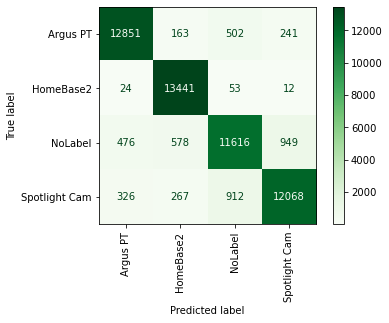

In [26]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, xticks_rotation='vertical', cmap='Greens')

#### Feature Importance

In [27]:
from sklearn.inspection import permutation_importance

y_test = lb.transform(y_test)

importances = forest.feature_importances_
forest_importances_MDI = pd.Series(importances, index=training_features)
forest_importances_MDI_std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

importances = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=4
)
forest_importances_permute = pd.Series(importances.importances_mean, index=training_features)
forest_importances_permute_std = importances.importances_std

In [28]:
fig = make_subplots(rows=2, cols=1)

trace1 = fig.add_trace(
    go.Bar(
      x=training_features,
      y=forest_importances_MDI,
      error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=forest_importances_MDI_std,
            visible=True
            ),
      name="Feature importances using MDI",
      # text=forest_importances_MDI
      ),
    row=1, col=1
)

trace2 = fig.add_trace(
    go.Bar(
      x=training_features,
      y=forest_importances_permute,
      error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=forest_importances_permute_std,
            visible=True
            ),
      name="Feature importances using permutation",
      # text=forest_importances_permute
      ),
    row=2, col=1
)

fig.update_layout(
  height=600, 
  width=900, 
)
fig.update_layout(
  legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="left",
    x=0
    )
  )

fig.update_yaxes(title="Mean decrease in impurity", row=1, col=1)
fig.update_yaxes(title="Mean decrease in accuracy", row=2, col=1)
fig.update_layout(margin=dict(t=10, b=10))
fig.write_image("assets/feat_importances.pdf")
fig.show()

#### Optimization

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion for measuring the quality of a split
criterion = ['gini', 'entropy']

random_grid = {
  'n_estimators': n_estimators,
  'criterion': criterion,
  'max_depth': max_depth,
  'min_samples_split': min_samples_split,
  'min_samples_leaf': min_samples_leaf,
  'max_features': max_features,
  'bootstrap': bootstrap
  }

In [30]:
best_forest_path = Path("rf_classifier.joblib")

if not best_forest_path.is_file():
  rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
  rf_random.fit(X, y)

In [31]:
try:
  dump(rf_random.best_estimator_, best_forest_path)
except NameError:
  best_forest = load(best_forest_path)

In [32]:
best_forest_time = %timeit -o -p 10 -r 20 -n 20 y_pred = best_forest.predict(X_test.sample(1))

142.9547443 ms ± 27.59192642 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [33]:
best_forest_time.average

0.1429547442500001

In [34]:
print(forest_df)

y_pred = best_forest.predict(X_test)
try:
  y_test = lb.inverse_transform(y_test)
except np.AxisError:
  print("y_test already in original form.")
y_pred = lb.inverse_transform(y_pred)

acc = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

best_forest_df = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True))
print(best_forest_df)

               Argus PT     HomeBase2       NoLabel  Spotlight Cam  accuracy  \
precision      0.939607      0.930237      0.887870       0.909420  0.917344   
recall         0.934143      0.993422      0.852926       0.889118  0.917344   
f1-score       0.936867      0.960792      0.870047       0.899154  0.917344   
support    13757.000000  13530.000000  13619.000000   13573.000000  0.917344   

              macro avg  weighted avg  
precision      0.916783      0.916825  
recall         0.917402      0.917344  
f1-score       0.916715      0.916709  
support    54479.000000  54479.000000  
               Argus PT     HomeBase2       NoLabel  Spotlight Cam  accuracy  \
precision      0.940509      0.939208      0.907914       0.926586   0.92911   
recall         0.964164      0.993422      0.854982       0.903853   0.92911   
f1-score       0.952190      0.965554      0.880653       0.915079   0.92911   
support    13757.000000  13530.000000  13619.000000   13573.000000   0.92911   

In [35]:
# Saves tree dot file in case RandomSearchCV was run
try:
  tree_ = tree.export_graphviz(
    rf_random.best_estimator_.estimators_[0],
    feature_names=training_features,
    max_depth=3,
    filled=True,
    rounded=True,
    out_file='assets/tree.dot'
    )

  os.system('dot -Tpdf assets/tree.dot -o assets/tree.pdf')
except NameError:
  pass

### Neighbor

In [36]:
y_pred = neighbor.predict(X_test)
try:
  y_test = lb.inverse_transform(y_test)
except np.AxisError:
  print("y_test already in original form.")
y_pred = lb.inverse_transform(y_pred)

acc = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
print(acc, f1_score)

y_test already in original form.
0.8968409845995705 0.8962726658175457


In [37]:
neighbor_df = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True))
neighbor_df

,Argus PT,HomeBase2,NoLabel,Spotlight Cam,accuracy,macro avg,weighted avg
precision,0.921382,0.851826,0.883109,0.939722,0.896841,0.899010,0.899109
recall,0.914952,0.979379,0.822674,0.870626,0.896841,0.896908,0.896841
f1-score,0.918156,0.911160,0.851821,0.903855,0.896841,0.896248,0.896273
support,13757.000000,13530.000000,13619.000000,13573.000000,0.896841,54479.000000,54479.000000


In [38]:
labels, counts = np.unique(y_test, return_counts=True)
for label, count_ in zip(labels, counts):
  print(f"{label}: {count_}")

Argus PT: 13757
HomeBase2: 13530
NoLabel: 13619
Spotlight Cam: 13573


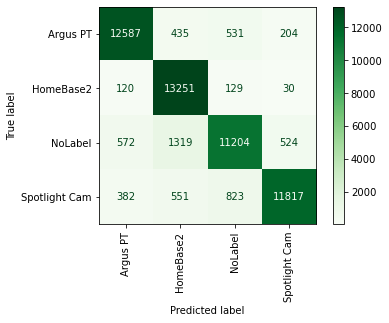

In [39]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, xticks_rotation='vertical', cmap='Greens')

### Machine

In [40]:
y_pred = machine.predict(X_test)
try:
  y_test = lb.inverse_transform(y_test)
except np.AxisError:
  print("y_test already in original form.")
y_pred = lb.inverse_transform(y_pred)

acc = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
print(acc, f1_score)

y_test already in original form.
0.2788230327282072 0.19607098554045596


In [44]:
machine_df = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True, zero_division=1))
machine_df

,Argus PT,HomeBase2,NoLabel,Spotlight Cam,accuracy,macro avg,weighted avg
precision,0.305898,0.482353,1.0,0.142181,0.278823,0.482608,0.482448
recall,0.853965,0.121212,0.0,0.132764,0.278823,0.276985,0.278823
f1-score,0.450443,0.193739,0.0,0.137311,0.278823,0.195373,0.196071
support,13757.000000,13530.000000,13619.0,13573.000000,0.278823,54479.000000,54479.000000


In [42]:
labels, counts = np.unique(y_test, return_counts=True)
for label, count_ in zip(labels, counts):
  print(f"{label}: {count_}")

Argus PT: 13757
HomeBase2: 13530
NoLabel: 13619
Spotlight Cam: 13573


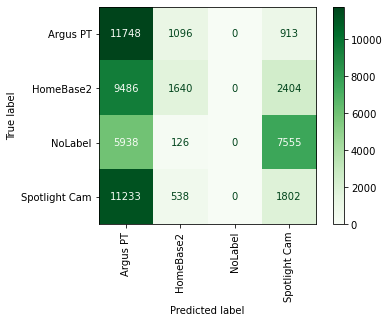

In [43]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, xticks_rotation='vertical', cmap='Greens')